In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Surgical-deepnet.csv")
df.tail()

,bmi,Age,asa_status,baseline_cancer,baseline_charlson,baseline_cvd,baseline_dementia,baseline_diabetes,baseline_digestive,baseline_osteoart,...,complication_rsi,dow,gender,hour,month,moonphase,mort30,mortality_rsi,race,complication
14630,18.79,14.1,1,0,1,0,0,0,0,0,...,-0.54,1,0,7.78,0,1,0,-0.16,1,1
14631,19.65,12.6,0,0,0,0,0,0,0,0,...,-1.42,4,0,8.40,6,1,0,-0.77,1,1
14632,14.84,12.6,1,0,0,0,0,0,0,0,...,0.65,0,0,13.25,3,3,0,0.99,1,1
14633,17.75,8.9,0,0,1,0,0,0,1,0,...,-0.50,0,1,8.30,5,0,0,0.17,1,1
14634,14.40,6.1,1,0,1,0,0,0,1,0,...,0.78,2,0,7.65,4,1,0,1.06,0,1


In [4]:
df.isnull().sum()

bmi                    0
Age                    0
asa_status             0
baseline_cancer        0
baseline_charlson      0
baseline_cvd           0
baseline_dementia      0
baseline_diabetes      0
baseline_digestive     0
baseline_osteoart      0
baseline_psych         0
baseline_pulmonary     0
ahrq_ccs               0
ccsComplicationRate    0
ccsMort30Rate          0
complication_rsi       0
dow                    0
gender                 0
hour                   0
month                  0
moonphase              0
mort30                 0
mortality_rsi          0
race                   0
complication           0
dtype: int64

In [5]:
X = df.drop('complication', axis=1).copy().values
Y = df['complication'].copy().values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((11708, 24), (2927, 24), (11708,), (2927,))

In [55]:
class Perceptron:
    def __init__(self, input_length, learning_rate, function="sigmoid"):
        self.W = np.random.rand(input_length)
        self.b = np.random.rand(1)
        self.learning_rate = learning_rate
        self.function = function
    
    def activation(self, x):
        if self.function == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif self.function == "relu":
            return np.maximum(0, x)
        elif self.function == "tanh":
            return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        elif self.function == "linear":
            return x
        elif self.function == "Leaky ReLU":
            if x >= 0:
                return x
            else:
                return 0.2*x
        else:
            raise Exception("Not supported activation function")

    def forward(self, x):
        return self.activation(x @ self.W + self.b)
    
    def back_propagation(self, x_train, y_train, y_pred):
        dW = (y_pred - y_train) * x_train
        db = (y_pred - y_train)
        return dW, db
    
    def update(self, dW, db):
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db

    def fit(self, X_train, Y_train, X_test, Y_test, epochs):
        L_train = []
        A_train = []
        L_test = []
        A_test = []
        for epoch in tqdm(range(epochs)):
            for x_train, y_train in zip(X_train, Y_train):
                y_pred = self.forward(x_train)
                dW, db = self.back_propagation(x_train, y_train, y_pred)
                self.update(dW, db)
            loss_train, accuracy_train = self.evaluate(X_train, Y_train)
            loss_test, accuracy_test = self.evaluate(X_test, Y_test)
            L_train.append(loss_train)
            A_train.append(accuracy_train)
            L_test.append(loss_test)
            A_test.append(accuracy_test)
        return L_train, A_train, L_test, A_test

    def predict(self, X_test):
        Y_pred = []
        for x_test in X_test:
            y_pred = self.forward(x_test)
            Y_pred.append(y_pred)
        return np.array(Y_pred)
    
    def calc_loss(self, X_test, Y_test, metric='mse'):
        y_pred = self.predict(X_test)
        if metric == 'mse':
            loss = np.mean((y_pred - Y_test) ** 2)
        elif metric == 'mae':
            loss = np.mean(np.abs(y_pred - Y_test))
        else:
            raise Exception('Not supported metric')
        return loss
    
    def calc_accuracy(self, X_test, Y_test):
        Y_pred = self.predict(X_test)
        Y_pred = Y_pred > 0.5
        accuracy = np.mean(Y_pred == Y_test)
        return accuracy

    def evaluate(self, X_test, Y_test):
        loss = self.calc_loss(X_test, Y_test)
        accuracy = self.calc_accuracy(X_test, Y_test)
        return loss, accuracy


In [50]:
model = Perceptron(X.shape[1], learning_rate=0.0001)
L_train, A_train, L_test, A_test = model.fit(X_train, Y_train, X_test, Y_test, epochs=200)

100%|██████████| 200/200 [18:04<00:00,  5.42s/it]


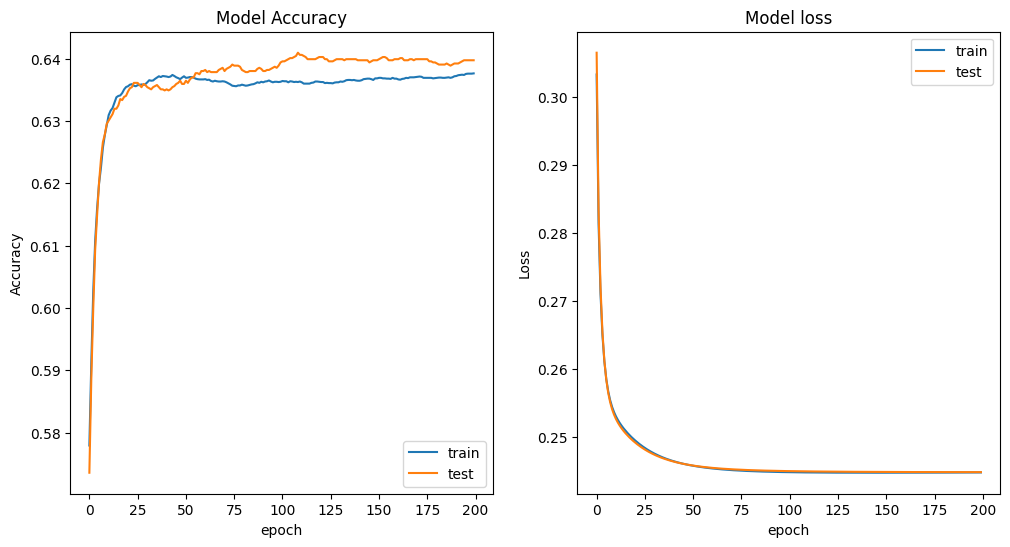

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(A_train)
ax1.plot(A_test)
ax1.set_title("Model Accuracy")
ax1.set_xlabel("epoch")
ax1.set_ylabel("Accuracy")
ax1.legend(['train','test'])

ax2.plot(L_train)
ax2.plot(L_test)
ax2.set_title("Model loss")
ax2.set_xlabel("epoch")
ax2.set_ylabel("Loss")
ax2.legend(['train','test'])

plt.show()

In [56]:
functions = ['sigmoid', 'relu', 'tanh', 'linear', 'Leaky ReLU']
for function in functions:
    model = Perceptron(X.shape[1], learning_rate=0.0001, function=function)
    L_train, A_train, L_test, A_test = model.fit(X_train, Y_train, X_test, Y_test, epochs=100)
    print(f'function: {function}, accuracy: {A_test[-1]}, loss: {L_test[-1]}')

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:56<00:00,  4.77s/it]


function: sigmoid, accuracy: 0.6397621709169801, loss: 0.2449088609972535


100%|██████████| 100/100 [07:36<00:00,  4.57s/it]


function: relu, accuracy: 0.6765826315296167, loss: 0.256461451164699


100%|██████████| 100/100 [07:55<00:00,  4.76s/it]


function: tanh, accuracy: 0.6826329419589232, loss: 0.2378631335641936


100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


function: linear, accuracy: 0.6895475824495593, loss: 0.2438685840380976


100%|██████████| 100/100 [07:15<00:00,  4.35s/it]

function: Leaky ReLU, accuracy: 0.6798670857626689, loss: 0.2515838352872938


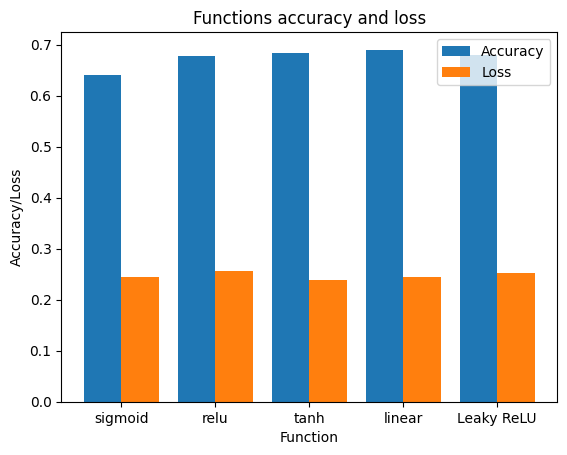

In [66]:
Accuracy = [0.64, .677, .683, .69, .68]
Loss = [0.245, .256, .238, .244, .252]
function = ['sigmoid', 'relu', 'tanh', 'linear', 'Leaky ReLU']

X_axis = np.arange(len(function))
plt.bar(X_axis - 0.2, Accuracy, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, Loss, 0.4, label = 'Loss')

plt.xticks(X_axis, function)
plt.title("Functions accuracy and loss")
plt.xlabel("Function")
plt.ylabel("Accuracy/Loss")
plt.legend(['Accuracy','Loss'])

plt.show()

In [9]:
model.evaluate(X_test, Y_test)

(0.26118137884295556, 0.6914491085844842)

In [52]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred > 0.5

In [57]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, Y_pred)

array([[1933,  271],
       [ 339,  384]], dtype=int64)

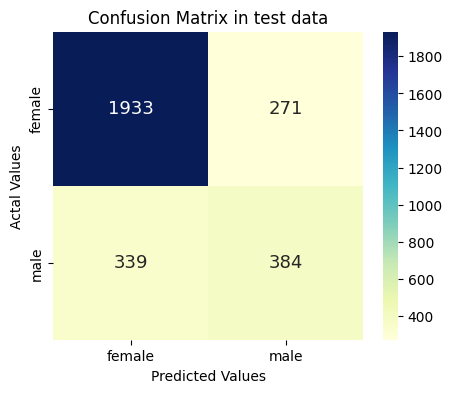

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb

cm = confusion_matrix(Y_test, Y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['female','male'], 
                     columns = ['female','male'])

plt.figure(figsize=(5,4))
sb.heatmap(cm_df, annot=True, fmt='d', annot_kws={'size':13}, cmap="YlGnBu")
plt.title('Confusion Matrix in test data')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [12]:
# precision and recall

from sklearn.metrics import precision_score, recall_score

print('precision_score: ', precision_score(Y_test, Y_pred))
print('recall_score: ', recall_score(Y_test, Y_pred))

precision_score:  0.6741573033707865
recall_score:  0.33195020746887965
